<a href="https://colab.research.google.com/github/minyoung347/highfrequency/blob/main/highfrequency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/minyoung347/highfrequency.git

import os
import sys

sys.path.insert(0,'/content/highfrequency')
os.chdir('/content/highfrequency')

fatal: destination path 'highfrequency' already exists and is not an empty directory.


In [ ]:
import typing
from typing import Tuple
import json
import os
import sys

import torch
from torch import nn
from torch import optim
from sklearn.preprocessing import StandardScaler
import joblib

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

import utils
from modules import Encoder, Decoder
from custom_types import DaRnnNet, TrainData, TrainConfig
from utils import numpy_to_tensor
from constants import device
from IPython.display import Image

logger = utils.setup_log()
logger.info(f"Using computation device: {device}")

print(device)

2023-06-13 20:50:18,521 - VOC_TOPICS - INFO - Using computation device: cuda


cuda


# 0. 데이터 불러오기

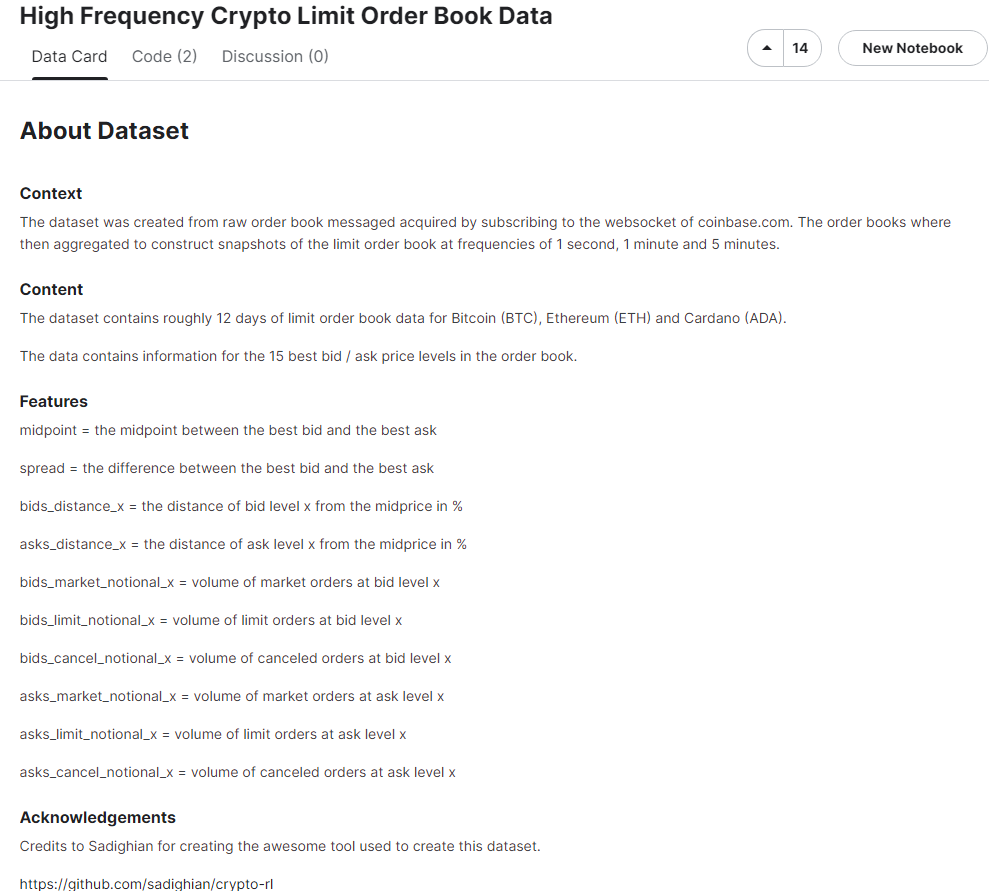

In [ ]:
# Kaggle에 공개된 고빈도 오더북 데이터
# 출처: https://www.kaggle.com/datasets/martinsn/high-frequency-crypto-limit-order-book-data
Image("data/data.png")

In [ ]:
df = pd.read_csv('data/BTC_5min.csv')

df['system_time'] = df['system_time'].str.slice(0,26)
df['system_time'] = pd.to_datetime(df['system_time'], format='%Y-%m-%d %H:%M:%S.%f')
df.drop(columns='Unnamed: 0', inplace=True)

print(np.shape(df))

(3367, 155)


In [ ]:
print(df.columns.tolist())

['system_time', 'midpoint', 'spread', 'buys', 'sells', 'bids_distance_0', 'bids_distance_1', 'bids_distance_2', 'bids_distance_3', 'bids_distance_4', 'bids_distance_5', 'bids_distance_6', 'bids_distance_7', 'bids_distance_8', 'bids_distance_9', 'bids_distance_10', 'bids_distance_11', 'bids_distance_12', 'bids_distance_13', 'bids_distance_14', 'bids_notional_0', 'bids_notional_1', 'bids_notional_2', 'bids_notional_3', 'bids_notional_4', 'bids_notional_5', 'bids_notional_6', 'bids_notional_7', 'bids_notional_8', 'bids_notional_9', 'bids_notional_10', 'bids_notional_11', 'bids_notional_12', 'bids_notional_13', 'bids_notional_14', 'bids_cancel_notional_0', 'bids_cancel_notional_1', 'bids_cancel_notional_2', 'bids_cancel_notional_3', 'bids_cancel_notional_4', 'bids_cancel_notional_5', 'bids_cancel_notional_6', 'bids_cancel_notional_7', 'bids_cancel_notional_8', 'bids_cancel_notional_9', 'bids_cancel_notional_10', 'bids_cancel_notional_11', 'bids_cancel_notional_12', 'bids_cancel_notional_13

In [ ]:
for k in range(15):
    exec(f"df['bid_{k}'] = df.midpoint + df.midpoint * df.bids_distance_{k}")
    exec(f"df['ask_{k}'] = df.midpoint + df.midpoint * df.asks_distance_{k}")

for k in range(15):
    if k == 0:
        exec(f"df['bid_vol_{k}'] = df.bids_limit_notional_{k}")
        exec(f"df['ask_vol_{k}'] = df.asks_limit_notional_{k}")
    else:
        exec(f"df['bid_vol_{k}'] = df.bid_vol_{k-1} + df.bids_limit_notional_{k}")
        exec(f"df['ask_vol_{k}'] = df.ask_vol_{k-1} + df.asks_limit_notional_{k}")

    exec(f"df['depth_{k}'] = df.bids_limit_notional_{k} + df.asks_limit_notional_{k}")
    exec(f"df['liquidity_{k}'] = df['spread'] / df['depth_{k}']")

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [ ]:
for col in df.columns:
    if col != 'system_time':
        exec(f"df['{col}_diff'] = df['{col}'].diff(1)")

In [ ]:
df['depth_14_diff_10'] = df['depth_14'].diff(10)
df['depth_14_diff_10_shift'] = df['depth_14_diff_10'].shift(-10).copy()
df = df.dropna()

# 1. 데이터 탐색

In [ ]:
print(np.shape(df))

(3327, 492)


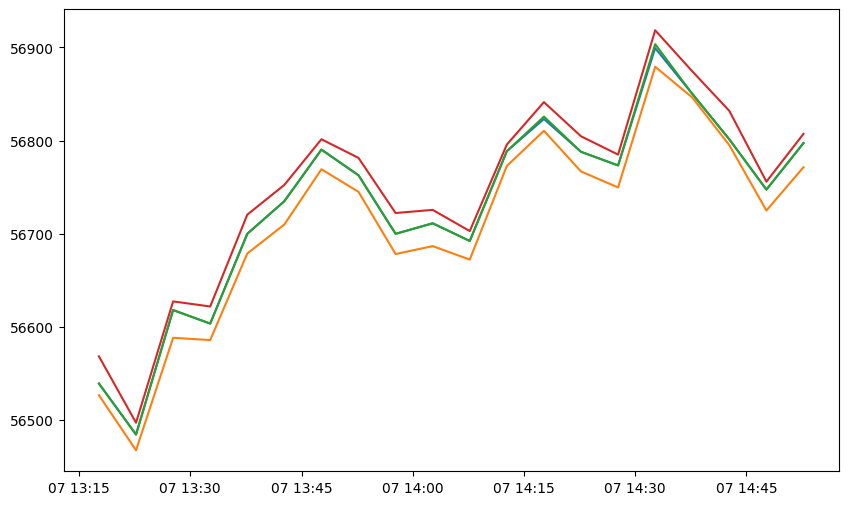

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(df.system_time[:20], (df.bid_0)[:20])
ax.plot(df.system_time[:20], (df.bid_14)[:20])
ax.plot(df.system_time[:20], (df.ask_0)[:20])
ax.plot(df.system_time[:20], (df.ask_14)[:20])
plt.show()

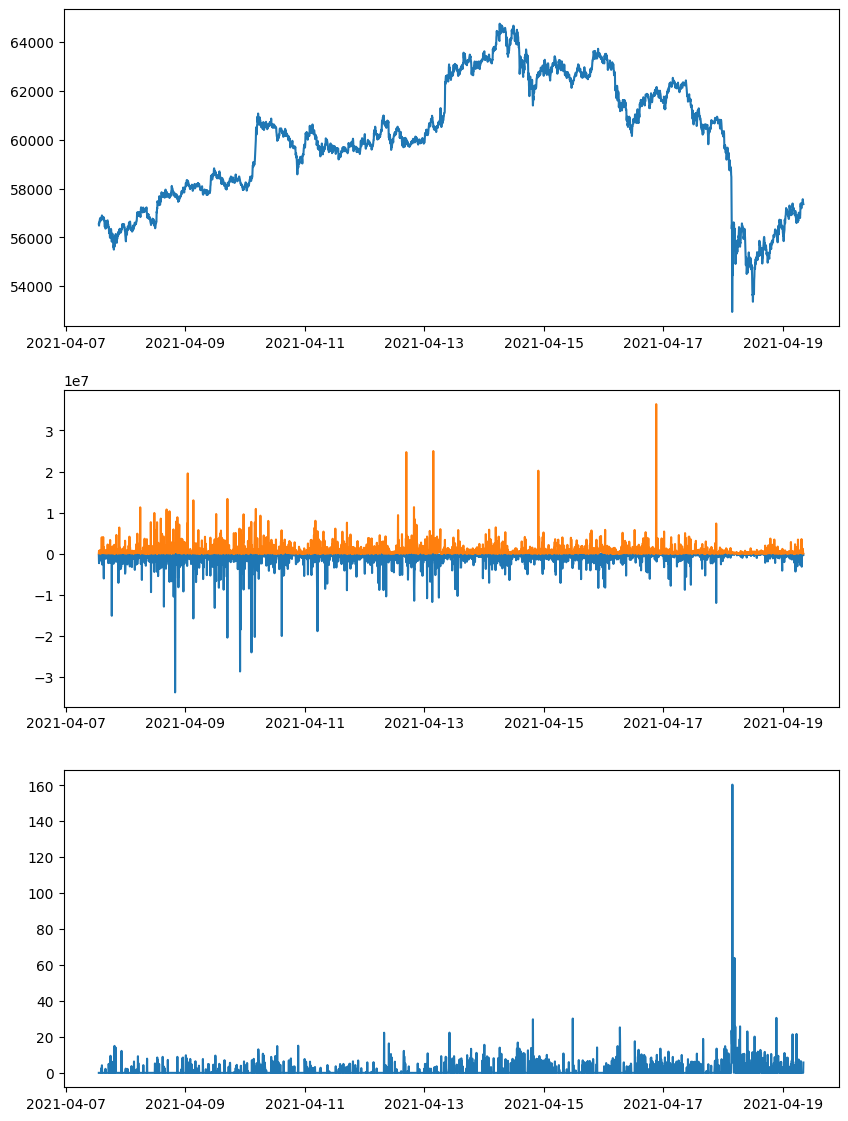

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(10, 14))
ax[0].plot(df.system_time, df.midpoint)

ax[1].plot(df.system_time, - df.bid_vol_4)
ax[1].plot(df.system_time, df.ask_vol_4)

ax[2].plot(df.system_time, df.spread)

plt.show()

# 2. 딥러닝 모델 설정

## 전처리

In [ ]:
def preprocess_data(dat, col_names, scale=None) -> Tuple[TrainData, StandardScaler]:
    if scale is None:
        scale = StandardScaler().fit(dat)
    proc_dat = scale.transform(dat)
    proc_dat = np.array(proc_dat)
    mask = np.ones(proc_dat.shape[1], dtype=bool)
    dat_cols = list(dat.columns)
    for col_name in col_names:
        mask[dat_cols.index(col_name)] = False

    feats = proc_dat[:, mask]
    targs = proc_dat[:, ~mask]

    return TrainData(feats, targs), scale

## DA-RNN 모델 생성

In [ ]:
def da_rnn(train_data: TrainData, n_targs: int, encoder_hidden_size=50, decoder_hidden_size=50, # 50
           T=10, learning_rate=0.001, batch_size=128):

    train_cfg = TrainConfig(T, int(train_data.feats.shape[0] * 0.7), batch_size, nn.MSELoss())
    logger.info(f"Training size: {train_cfg.train_size:d}.")

    enc_kwargs = {"input_size": train_data.feats.shape[1], "hidden_size": encoder_hidden_size, "T": T}
    encoder = Encoder(**enc_kwargs).to(device)
    with open(os.path.join("data", "enc_kwargs.json"), "w") as fi:
        json.dump(enc_kwargs, fi, indent=4)

    dec_kwargs = {"encoder_hidden_size": encoder_hidden_size,
                  "decoder_hidden_size": decoder_hidden_size, "T": T, "out_feats": n_targs}
    decoder = Decoder(**dec_kwargs).to(device)
    with open(os.path.join("data", "dec_kwargs.json"), "w") as fi:
        json.dump(dec_kwargs, fi, indent=4)

    encoder_optimizer = optim.Adam(
        params=[p for p in encoder.parameters() if p.requires_grad],
        lr=learning_rate, weight_decay = 1e-6) # weight_decay = 1e-5
    decoder_optimizer = optim.Adam(
        params=[p for p in decoder.parameters() if p.requires_grad],
        lr=learning_rate, weight_decay = 1e-6)
    da_rnn_net = DaRnnNet(encoder, decoder, encoder_optimizer, decoder_optimizer)

    return train_cfg, da_rnn_net

## 학습 알고리즘

In [ ]:
def train(net: DaRnnNet, train_data: TrainData, t_cfg: TrainConfig, n_epochs=10, save_plots=True):
    iter_per_epoch = int(np.ceil(t_cfg.train_size * 1. / t_cfg.batch_size))
    iter_losses = np.zeros(n_epochs * iter_per_epoch)
    epoch_losses = np.zeros(n_epochs)
    iter_losses_val = np.zeros(n_epochs * iter_per_epoch) #
    epoch_losses_val = np.zeros(n_epochs) #
    logger.info(f"Iterations per epoch: {t_cfg.train_size * 1. / t_cfg.batch_size:3.3f} ~ {iter_per_epoch:d}.")

    n_iter = 0

    for e_i in range(n_epochs):
        perm_idx = np.random.permutation(t_cfg.train_size - t_cfg.T)

        t_iter = 0
        for t_i in range(0, t_cfg.train_size, t_cfg.batch_size):
            batch_idx = perm_idx[t_i : t_i + t_cfg.batch_size]
            feats, y_history, y_target = prep_train_data(batch_idx, t_cfg, train_data)

            loss, attn_weight = train_iteration(net, t_cfg.loss_func, feats, y_history, y_target)
            if t_iter == 0:
                torch.save(attn_weight, './pt_save/attn_w_{}_{}_{}_{}_{}_{}_{}_{}_{}.pt'.format(exp, add_random, lr, num_epoch, bs, tc, hs, e_i, t_iter))
                torch.save(y_target, './pt_save/y_target_{}_{}_{}_{}_{}_{}_{}_{}_{}.pt'.format(exp, add_random, lr, num_epoch, bs, tc, hs, e_i, t_iter))
                y_test_pred = predict(net, train_data, #
                                  t_cfg.train_size, t_cfg.batch_size, t_cfg.T, #
                                  on_train=False) #
                torch.save(y_test_pred, './pt_save/y_pred_{}_{}_{}_{}_{}_{}_{}_{}_{}.pt'.format(exp, add_random, lr, num_epoch, bs, tc, hs, e_i, t_iter))

            y_test_pred = predict(net, train_data, #
                                  t_cfg.train_size, t_cfg.batch_size, t_cfg.T, #
                                  on_train=False) #
            # TODO: make this MSE and make it work for multiple inputs
            val_loss = y_test_pred - train_data.targs[t_cfg.train_size:] #
            iter_losses_val[e_i * iter_per_epoch + t_i // t_cfg.batch_size] = np.mean(np.abs(val_loss)) #


            iter_losses[e_i * iter_per_epoch + t_i // t_cfg.batch_size] = loss
            # if (j / t_cfg.batch_size) % 50 == 0:
            #    self.logger.info("Epoch %d, Batch %d: loss = %3.3f.", i, j / t_cfg.batch_size, loss)

            file_iter_loss = open('./loss_save/iter_loss_{}_{}_{}_{}_{}_{}_{}.csv'.format(exp, add_random, lr, num_epoch, bs, tc, hs),'a')
            file_iter_loss.write('{}, {}, {}, {}\n'.format(e_i, n_iter, loss, np.mean(np.abs(val_loss))))
            file_iter_loss.close()

            n_iter += 1

            adjust_learning_rate(net, n_iter)

            t_iter += 1

        epoch_losses[e_i] = np.mean(iter_losses[range(e_i * iter_per_epoch, (e_i + 1) * iter_per_epoch)])
        epoch_losses_val[e_i] = np.mean(iter_losses_val[range(e_i * iter_per_epoch, (e_i + 1) * iter_per_epoch)])

        file_epoch_loss = open('./loss_save/epoch_loss_{}_{}_{}_{}_{}_{}_{}.csv'.format(exp, add_random, lr, num_epoch, bs, tc, hs),'a')
        file_epoch_loss.write('{}, {}, {}, {}\n'.format(e_i, n_iter, np.mean(iter_losses[range(e_i * iter_per_epoch, (e_i + 1) * iter_per_epoch)]), np.mean(np.abs(val_loss)), np.mean(iter_losses_val[range(e_i * iter_per_epoch, (e_i + 1) * iter_per_epoch)])))
        file_epoch_loss.close()


        if e_i % 10 == 0:
            y_test_pred = predict(net, train_data,
                                  t_cfg.train_size, t_cfg.batch_size, t_cfg.T,
                                  on_train=False)
            # TODO: make this MSE and make it work for multiple inputs
            val_loss = y_test_pred - train_data.targs[t_cfg.train_size:]
            #logger.info(f"Epoch {e_i:d}, niter {n_iter:d}, train loss: {epoch_losses[e_i]:3.3f}, val loss: {np.mean(np.abs(val_loss))}.")
            logger.info(f"Epoch {e_i:d}, niter {n_iter:d}, train loss: {epoch_losses[e_i]}, val loss: {np.mean(np.abs(val_loss))}.")


            y_train_pred = predict(net, train_data,
                                   t_cfg.train_size, t_cfg.batch_size, t_cfg.T,
                                   on_train=True)

            plt.figure(figsize=(10,7))
            #plt.subplot(1,3,1)
            plt.plot(range(1, 1 + len(train_data.targs)), train_data.targs,
                     'r', label="True")
            plt.plot(range(t_cfg.T, len(y_train_pred) + t_cfg.T), y_train_pred,
                     'g' ,label='Predicted - Train')
            plt.plot(range(t_cfg.T + len(y_train_pred), len(train_data.targs) + 1), y_test_pred,
                     'b', label='Predicted - Test')
            plt.legend(loc='upper left')
            #plt.show()
            #plt.subplot(1,3,2)
            #plt.scatter(train_data.targs[:len(y_train_pred)], y_train_pred)
            #plt.subplot(1,3,3)
            #plt.scatter(train_data.targs[len(y_train_pred):], y_test_pred)
            utils.save_or_show_plot("pred_{}_{}_{}_{}_{}_{}_{}_{}.png".format(exp, add_random, lr, num_epoch, bs, tc, hs, e_i), save_plots)
            plt.close()

            '''
            correct_case = 0
            uncorrect_case = 0
            for i, ii in zip(train_data.targs[:len(y_train_pred)], y_train_pred):
                if i != 0:
                    if np.sign(i) == np.sign(ii):
                        correct_case += 1
                    else:
                        uncorrect_case += 1
            acc_train = correct_case / (correct_case + uncorrect_case)

            correct_case = 0
            uncorrect_case = 0
            for i, ii in zip(train_data.targs[len(y_train_pred):], y_test_pred):
                if i != 0:
                    if np.sign(i) == np.sign(ii):
                        correct_case += 1
                    else:
                        uncorrect_case += 1
            acc_test = correct_case / (correct_case + uncorrect_case)

            file = open('./pred_save/acc_{}_{}_{}_{}_{}_{}_{}.csv'.format(exp, add_random, lr, num_epoch, bs, tc, hs),'a')
            file.write('{}, {}\n'.format(e_i, n_iter, acc_train, acc_test))
            file.close()
            '''

    return iter_losses, epoch_losses, iter_losses_val, epoch_losses_val


def prep_train_data(batch_idx: np.ndarray, t_cfg: TrainConfig, train_data: TrainData):
    feats = np.zeros((len(batch_idx), t_cfg.T - 1, train_data.feats.shape[1]))
    y_history = np.zeros((len(batch_idx), t_cfg.T - 1, train_data.targs.shape[1]))
    y_target = train_data.targs[batch_idx + t_cfg.T]

    for b_i, b_idx in enumerate(batch_idx):
        start, stop = b_idx, b_idx + t_cfg.T - 1
        feats[b_i, :, :] = train_data.feats[start : stop, :]
        y_history[b_i, :] = train_data.targs[start : stop]

    return feats, y_history, y_target


def adjust_learning_rate(net: DaRnnNet, n_iter: int):
    # TODO: Where did this Learning Rate adjustment schedule come from?
    # Should be modified to use Cosine Annealing with warm restarts https://www.jeremyjordan.me/nn-learning-rate/
    #if n_iter % 10000 == 0 and n_iter > 0:
    if n_iter % 1000 == 0 and n_iter > 0:
        for enc_params, dec_params in zip(net.enc_opt.param_groups, net.dec_opt.param_groups):
            enc_params['lr'] = enc_params['lr'] * 0.9
            dec_params['lr'] = dec_params['lr'] * 0.9


def train_iteration(t_net: DaRnnNet, loss_func: typing.Callable, X, y_history, y_target):
    t_net.enc_opt.zero_grad()
    t_net.dec_opt.zero_grad()

    input_weighted, input_encoded, attn_w = t_net.encoder(numpy_to_tensor(X))
    y_pred = t_net.decoder(input_encoded, numpy_to_tensor(y_history))

    y_true = numpy_to_tensor(y_target)
    loss = loss_func(y_pred, y_true)
    loss.backward()

    t_net.enc_opt.step()
    t_net.dec_opt.step()

    return loss.item(), attn_w

## 예측 알고리즘

In [ ]:
def predict(t_net: DaRnnNet, t_dat: TrainData, train_size: int, batch_size: int, T: int, on_train=False):
    out_size = t_dat.targs.shape[1]
    if on_train:
        y_pred = np.zeros((train_size - T + 1, out_size))
    else:
        y_pred = np.zeros((t_dat.feats.shape[0] - train_size, out_size))

    for y_i in range(0, len(y_pred), batch_size):
        y_slc = slice(y_i, y_i + batch_size)
        batch_idx = range(len(y_pred))[y_slc]
        b_len = len(batch_idx)
        X = np.zeros((b_len, T - 1, t_dat.feats.shape[1]))
        y_history = np.zeros((b_len, T - 1, t_dat.targs.shape[1]))

        for b_i, b_idx in enumerate(batch_idx):
            if on_train:
                start, stop = b_idx, b_idx + T - 1
            else:
                start, stop = b_idx + train_size - T, b_idx + train_size - 1

            X[b_i, :, :] = t_dat.feats[start : stop, :]
            y_history[b_i, :] = t_dat.targs[start : stop]

        y_history = numpy_to_tensor(y_history)
        _, input_encoded, _ = t_net.encoder(numpy_to_tensor(X))
        y_pred[y_slc] = t_net.decoder(input_encoded, y_history).cpu().data.numpy()

    return y_pred

# 3. 하이퍼파라미터 설정

In [ ]:
save_plots = True
debug = False

exp = 'BTC'
add_random = 0
lr = 0.001
num_epoch = 100
bs = 512
tc = 10
hs = 50
ehs = hs
dhs = hs

In [ ]:
if os.path.exists('./loss_save/iter_loss_{}_{}_{}_{}_{}_{}_{}.csv'.format(exp, add_random, lr, num_epoch, bs, tc, hs)):
    os.remove('./loss_save/iter_loss_{}_{}_{}_{}_{}_{}_{}.csv'.format(exp, add_random, lr, num_epoch, bs, tc, hs))
if os.path.exists('./loss_save/epoch_loss_{}_{}_{}_{}_{}_{}_{}.csv'.format(exp, add_random, lr, num_epoch, bs, tc, hs)):
    os.remove('./loss_save/epoch_loss_{}_{}_{}_{}_{}_{}_{}.csv'.format(exp, add_random, lr, num_epoch, bs, tc, hs))
if os.path.exists('./pred_save/final_{}_{}_{}_{}_{}_{}_{}.csv'.format(exp, add_random, lr, num_epoch, bs, tc, hs)):
    os.remove('./pred_save/final_{}_{}_{}_{}_{}_{}_{}.csv'.format(exp, add_random, lr, num_epoch, bs, tc, hs))

targ_cols = ['depth_14_diff_10_shift']
if 'system_time' in df.columns:
  df.drop(columns=['system_time'], inplace=True)

data, scaler = preprocess_data(df, targ_cols)

In [ ]:
da_rnn_kwargs = {"batch_size": bs, "T": tc, "encoder_hidden_size": ehs, "decoder_hidden_size": dhs} # 1024, 10, 50, 50
config, model = da_rnn(data, n_targs=len(targ_cols), learning_rate=lr, **da_rnn_kwargs) #.01

2023-06-13 20:56:41,493 - VOC_TOPICS - INFO - Training size: 2328.


# 4. 모델 학습

In [ ]:
iter_loss, epoch_loss, iter_loss_val, epoch_loss_val = train(model, data, config, n_epochs=num_epoch, save_plots=save_plots)
final_y_pred = predict(model, data, config.train_size, config.batch_size, config.T)

2023-06-13 21:01:41,138 - VOC_TOPICS - INFO - Iterations per epoch: 4.547 ~ 5.
2023-06-13 21:01:42,624 - VOC_TOPICS - INFO - Epoch 0, niter 5, train loss: 0.27342803180217745, val loss: 0.17918494821675535.
2023-06-13 21:01:54,865 - VOC_TOPICS - INFO - Epoch 10, niter 55, train loss: 0.24780166447162627, val loss: 0.19885073194685735.
2023-06-13 21:02:06,971 - VOC_TOPICS - INFO - Epoch 20, niter 105, train loss: 0.19689105153083802, val loss: 0.1951596295393355.
2023-06-13 21:02:19,305 - VOC_TOPICS - INFO - Epoch 30, niter 155, train loss: 0.1542489066720009, val loss: 0.185799974436576.
2023-06-13 21:02:31,066 - VOC_TOPICS - INFO - Epoch 40, niter 205, train loss: 0.14393255859613419, val loss: 0.17427666286881152.
2023-06-13 21:02:43,052 - VOC_TOPICS - INFO - Epoch 50, niter 255, train loss: 0.13782937079668045, val loss: 0.20201871806746027.
2023-06-13 21:02:55,139 - VOC_TOPICS - INFO - Epoch 60, niter 305, train loss: 0.12284563332796097, val loss: 0.22850513520303445.
2023-06-13 2

# 5. 모델 성능평가

In [ ]:
plt.figure()
plt.semilogy(range(len(iter_loss)), iter_loss, label='train loss')
plt.semilogy(range(len(iter_loss_val)), iter_loss_val, label='valiation loss')
utils.save_or_show_plot("iter_loss_{}_{}_{}_{}_{}_{}_{}.png".format(exp, add_random, lr, num_epoch, bs, tc, hs), save_plots)
plt.close()

plt.figure()
plt.semilogy(range(len(epoch_loss)), epoch_loss, label='epoch train loss')
plt.semilogy(range(len(epoch_loss_val)), epoch_loss_val, label='epoch valiadation loss')
utils.save_or_show_plot("epoch_loss_{}_{}_{}_{}_{}_{}_{}.png".format(exp, add_random, lr, num_epoch, bs, tc, hs), save_plots)
plt.close()

plt.figure()
plt.plot(final_y_pred, label='Predicted')
plt.plot(data.targs[config.train_size:], label="True")
plt.legend(loc='upper left')
utils.save_or_show_plot("final_predicted_{}_{}_{}_{}_{}_{}_{}.png".format(exp, add_random, lr, num_epoch, bs, tc, hs), save_plots)
plt.close()


correct_case = 0
uncorrect_case = 0
TP = 0
FP = 0
FN = 0
TN = 0
for i, ii in zip(data.targs[config.train_size:], final_y_pred):
    if i[0] != 0:
        if np.sign(i[0]) == np.sign(ii[0]):
            correct_case += 1
        else:
            uncorrect_case += 1

        if np.sign(i[0]) > 0:
            if np.sign(ii[0]) > 0:
                TP += 1
            elif np.sign(ii[0]) < 0:
                FN += 1
        elif np.sign(i[0]) < 0:
            if np.sign(ii[0]) > 0:
                FP += 1
            elif np.sign(ii[0]) < 0:
                TN += 1

acc_final = correct_case / (correct_case + uncorrect_case)
print(acc_final)


file_stat = open('./stat_save/stat_{}_{}_{}_{}_{}_{}_{}.csv'.format(exp, add_random, lr, num_epoch, bs, tc, hs),'a')
file_stat.write('{}, {}, {}, {}, {}\n'.format(acc_final, TP, FN, FP, TN))
file_stat.close()



file_iter_loss = open('./pred_save/final_{}_{}_{}_{}_{}_{}_{}.csv'.format(exp, add_random, lr, num_epoch, bs, tc, hs),'a')
for i, ii in zip(data.targs[config.train_size:], final_y_pred):
    file_iter_loss.write('{}, {}\n'.format(i[0], ii[0]))
file_iter_loss.close()

with open(os.path.join("data", "da_rnn_kwargs.json"), "w") as fi:
    json.dump(da_rnn_kwargs, fi, indent=4)

joblib.dump(scaler, os.path.join("data", "scaler.pkl"))
torch.save(model.encoder.state_dict(), os.path.join("data", "encoder.torch"))
torch.save(model.decoder.state_dict(), os.path.join("data", "decoder.torch"))

0.6488625123639961


# 6. 변수 분석

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt


firm_num = 1
start_day = 1
end_day = 169
add_random = 0
# num_variables = 81 # exclude target variable
num_variables = 90 # exclude target variable
lr = 0.01
num_epoch = 10
bs = 1024
tc = 10
ehs = 100
dhs = 100
agg_size = 100

e_i = 1
t_iter = 0

attn_w = torch.load('./pt_save/attn_w_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}.pt'.format(firm_num, start_day, end_day, add_random, num_variables, lr, num_epoch, bs, tc, ehs, dhs, agg_size, e_i, t_iter))
attn_w = attn_w.detach().cpu().numpy()

y_target = torch.load('./pt_save/y_target_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}.pt'.format(firm_num, start_day, end_day, add_random, num_variables, lr, num_epoch, bs, tc, ehs, dhs, agg_size, e_i))

In [ ]:
print(np.shape(attn_w))
print(np.shape(y_target))

(1024, 9, 90)
(1024, 1)


In [ ]:
# attn_positive = np.zeros(62*2)
# attn_negative = np.zeros(62*2)
attn_positive = np.zeros(num_variables)
attn_negative = np.zeros(num_variables)

print(np.shape(attn_w))
print(np.shape(y_target))

for i in range(len(y_target)-1):
    if y_target[i+1] - y_target[i] > 0:
        attn_positive += np.mean(attn_w[i+1], axis = 0)
    elif y_target[i+1] - y_target[i] < 0:
        attn_negative += np.mean(attn_w[i+1], axis = 0)

(1024, 9, 90)
(1024, 1)


ValueError: operands could not be broadcast together with shapes (81,) (90,) (81,) 

In [ ]:
plt.plot(attn_positive)
plt.savefig('test.png')